# 1 Redes Completamente Conectadas

Nesta parte do trabalho são utilizados dados históricos de crediário oferecido aos clientes de uma instituição financeira. O intuito é treinar um modelo de rede neural para classificação binária que indicará se um novo cliente pagará ou não a dívida ao solicitar um empréstimo.

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn.apionly as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
sn.set()

Obtendo o conjunto de treinamento

In [4]:
df_train = pd.read_table('credtrain.txt', delim_whitespace=True, header=0)
df_train.head()

,esct,ndep,renda,tipor,vbem,nparc,vparc,tel,idade,resms,entrada,classe
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


Obtendo o conjunto de teste

In [5]:
df_test = pd.read_table('credtest.txt', delim_whitespace=True, header=0)
df_test.head()

,esct,ndep,renda,tipor,vbem,nparc,vparc,tel,idade,resms,entrada,classe
0,0,2,500,1,618,10,85,0,36,6,0,0
1,1,0,813,0,552,4,119,0,43,48,119,1
2,3,0,350,0,488,12,66,0,43,0,0,1
3,1,0,1530,0,381,1,398,0,28,48,0,1
4,0,0,688,1,396,10,60,0,49,72,0,1


Os dados de entrada são separados em duas matrizes $X$ e $y$, respectivamente, a matriz de treinamento e a matriz alvo. Sendo assim, a matriz $X$ tem somente as caracteristicas e $y$, `labels` da classificação binária (=1 se o cliente pagou a dívida). Como os dados de treinamento e teste já são fornecidos separadamente, não é necessário usar a função `train_test_split` da biblioteca `sklearn`.

In [6]:
X_train = df_train.values[:,:11]
y_train = df_train.values[:,-1]
print('Dimensões de X', X_train.shape)
print('Dimensões de y', y_train.shape)

X_test = df_test.values[:,:11]
y_test = df_test.values[:,-1]

Dimensões de X (1500, 11)
Dimensões de y (1500,)


Para tratar a questão das `features` com ordem de grandeza distintas normalmente são utilizadas técnicas de normalização. Nesta parte do trabalho aplica-se `MinMaxScaler`, que essencialmente, reduz o intervalo das variaveis de forma que elas estejam entre 0 e 1 (ou -1 a 1, se houver valores negativos).

In [7]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Usando `GridSearch` é possível encontrar os melhores hiperparâmetros para o classificador. Para isso é necessário fornecer intervalos dos valores para cada hiperparâmetro e o `GridSearch` tentará todas as combinações. Ao final, o resultado é a melhor combinação para o modelo.

In [8]:
parameters = {'solver': ['lbfgs'], 'max_iter': [100, 250, 500], 'alpha': 10.0 ** -np.arange(2, 5), 
              'hidden_layer_sizes':np.arange(100, 500, 50)}
grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
grid.fit(X_train, y_train)
print('Melhores hiperparâmetros \n', grid.best_params_)

Melhores hiperparâmetros 
 {'alpha': 0.0001, 'hidden_layer_sizes': 150, 'max_iter': 100, 'solver': 'lbfgs'}


O treinamento dos inputs de entrada são realizados por meio de uma rede neural MLP (*multi-layer perceptron*) com propagação do erro (*error backpropagation*), chamada `MLPCassifier` do `sklearn`. O MLP possui uma camada de entrada, uma camada oculta e a camada de saída. Para otimização dos pesos, escolheu-se o `lbfgs`, visto que na documentação do `MLPClassifier` essa abordagem é a melhor para obter uma conversão mais rápida em *dataset* pequenos.  Com base nos melhores hiperparâmetros selecionados anteriormente, a camada oculta tem $150$ unidades, o termo de regularização (L2) escolhido de $0,0001$ e o máximo de iterações de $100$.

In [9]:
model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(150,), max_iter=100, alpha=0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
print('Acurária: {0:.2f}'.format(accuracy_score(y_test, y_pred)))

Acurária: 0.89


A acurácia é a proporção de predições corretas, sem levar em consideração o que é positivo ou negativo. Como essa medida é suscetível a desbalanceamento, ou seja, somente predizer corretamente uma única classe, uma alternativa para melhor compreensão do comportamento do classificador, é a utilização da matriz de confusão, conforme exibido abaixo. 

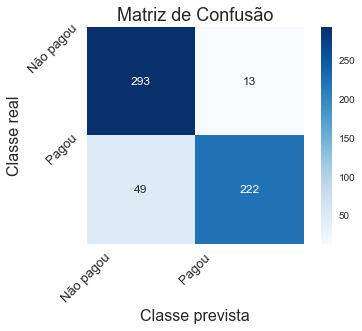

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred)

conf_df = pd.DataFrame(conf_matrix)
plt.figure();
sn.heatmap(conf_df, annot=True, cmap='Blues', fmt='g', square=True);
plt.ylabel('Classe real', fontsize=16);
plt.xlabel('Classe prevista', fontsize=16);
classes = ['Não pagou', 'Pagou']
tick_marks = np.arange(len(classes))
plt.title('Matriz de Confusão', fontsize=18);
plt.xticks(tick_marks, classes, rotation=45, fontsize=13);
plt.yticks(tick_marks, classes, rotation=45, fontsize=13);

Ao interpretar a matriz de confusão tem-se que:
- O modelo classificou 293 instâncias como "Não pagou" a dívida em que **realmente** a pessoa "Não pagou" a dívida
- O modelo classificou 13 instâncias como "Pagou dívida" em que **na verdade** a pessoa "Não pagou" a dívida
- O modelo classificou 49 instâncias como "Não pagou" a dívida em que **na verdade** a pessoa "Pagou" a dívida
- O modelo classificou 222 instâncias como "Pagou" a dívida em que **realmente** a pessoa "Pagou" a dívida

Ao analisar a matriz de confusão e possível saber a acurária no modelo. Para isso, basta somar os valores da diagonal principal que indica os valores corretamente previstos (VERDADEIRO POSITIVO + VERDADEIRO NEGATIVO) divido pela soma de todos os valores da matriz. Outras medidas como sensibilidade, especificidade tambem são obtidas ao analisar a matriz de confusão.

# 2 Redes Convolucionais

O objetivo desta parte do trabalho é treinar modelos de redes neurais artificiais para classificar se determinada imagem contém ou não gato, usando o TensorFlow. O módulo de `layers` do TensorFlow fornece uma API de alto nível para a construção de uma rede neural. Ele fornece métodos que facilitam a criação de camadas densas (totalmente conectadas) e camadas convolucionais. As próximas sessões implementam as seguintes redes:
- Uma rede completamente conectada de uma única camada oculta e com uma camada de saida de duas unidades com softmax.
- Uma rede convolucional.

O método `load_dataset` é usado para ler os arquivos com o conjunto de dados de treinamento (`train catvnoncat.h5`) e teste (`test catvnoncat.h5`).

In [12]:
import h5py

In [13]:
def load_dataset():
    train_ds = h5py.File('./train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_ds['train_set_x'][:])
    train_set_y_orig = np.array(train_ds['train_set_y'][:])
    
    test_ds = h5py.File('./test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_ds['test_set_x'][:])
    test_set_y_orig = np.array(test_ds['test_set_y'][:])
    
    classes = np.array(test_ds['list_classes'][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [14]:
train_x, train_y, test_x, test_y, classes = load_dataset()
train_x.shape

(209, 64, 64, 3)

In [15]:
train_y.shape

(1, 209)

In [16]:
test_x.shape

(50, 64, 64, 3)

In [17]:
test_y.shape

(1, 50)

### Ajuste dos dados de entrada

A entrada de uma rede neural densa é um tensor de dimensão $m$ linhas, referente aos exemplos do conjunto de entrada, e $n$ colunas, que correspondem as *features*. Por isso, o reajuste em `train_x` e `test_x`, de forma que as matrizes tenham as seguintes dimensões: $m$ e $64x64x3$. A conversão para tipo `float32` é para evitar um erro no TensorFlow.

In [18]:
train_x = train_x.reshape(train_x.shape[0], -1).astype(np.float32)
train_x.shape

(209, 12288)

In [19]:
test_x = test_x.reshape(test_x.shape[0], -1).astype(np.float32)
test_x.shape

(50, 12288)

Já com as  matrizes de `labels`uma opção de transformação seria aplicar *one-hot encoding*, o que resultaria em matrizes de dimensões $m$ (número de exemplos) $x2$, visto que existem somente duas classes ("não-gato" e "gato"). No entanto, como a função `sparse_softmax_cross_entropy` é utilizada nas implementações abaixo, ela recebe como parâmetro um vetor com as classes de cada exemplo de dimensão $m$, não sendo necessário fazer *one-hot encoding*, mas sim torná-las vetores unidimensionais.

In [20]:
train_y = train_y.flatten()
train_y.shape

(209,)

In [21]:
test_y = test_y.flatten()
test_y.shape

(50,)

In [22]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)

## 2.1 Rede completamente conectada

Características do modelo:

- Camada densa oculta com $1.024$ neurônios e taxa de regularização (*dropout*) de $0,6$ (probabilidade de $60\%$ de qualquer unidade ser desligada durante o treinamento)
- Camada de saida com $2$ neurônios, um para cada classe (0–1)

In [55]:
def dense_model(features, labels, mode):
    # tensor de entrada
    input_layer = tf.reshape(features['x'], [-1, features['x'].shape[1]])

    # camda densa oculta (rede completamente conectada)
    dense_hidden = tf.layers.dense(inputs=input_layer, units=1024, activation=tf.nn.relu)

    dropout = tf.layers.dropout(inputs=dense_hidden, rate=0.6, training=mode == tf.estimator.ModeKeys.TRAIN)

    # camda densa de saída
    dense_output = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      'classes': tf.argmax(input=dense_output, axis=1),
      'probabilidades': tf.nn.softmax(dense_output, name='softmax_tensor')
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # cálculo do custo
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=dense_output)
 
    # otimização do custo na etapa de treinamento
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # métricas de avaliação na etapa de teste
    test_metric_ops = {'acurácia': tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=test_metric_ops)

Criação do estimador, uma classe do TensorFlow para realizar treinamento e avaliação do modelo. O argumento `model_fn` especifica a função do modelo a ser usada para treinamento, avaliação e previsão. Sendo assim, utilizou-se a função `dense_model` criada anteriormente.

In [56]:
dense_classifier = tf.estimator.Estimator(model_fn=dense_model, model_dir="./dense_model_d4")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './dense_model_d4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BCE431BEB8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Configuração do log para acompanhar o progresso durante o treinamento.

In [57]:
tensors_to_log = {'probabilidades': 'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

Treinamento do modelo

In [58]:
train_input = tf.estimator.inputs.numpy_input_fn(x={'x': train_x}, y=train_y, num_epochs=None, batch_size=50, shuffle=True)
dense_classifier.train(input_fn=train_input, steps=500, hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./dense_model_d4\model.ckpt.
INFO:tensorflow:probabilidades = [[0.5922245  0.40777552]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1. 

INFO:tensorflow:global_step/sec: 8.03152
INFO:tensorflow:probabilidades = [[1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.7487027  0.2512973 ]
 [0.25769612 0.74230385]
 [0.00000017 0.9999999 ]
 [0.9704459  0.02955412]
 [1.         0.00000001]
 [0.         1.        ]
 [0.9166585  0.08334153]
 [1.         0.        ]
 [1.         0.        ]
 [0.00035605 0.9996439 ]
 [0.5201304  0.4798696 ]
 [1.         0.        ]
 [1.         0.        ]
 [0.5222708  0.47772923]
 [0.99970657 0.00029338]
 [0.40403432 0.5959657 ]
 [0.9999901  0.00000985]
 [0.00666323 0.9933368 ]
 [0.9999995  0.0000005 ]
 [0.99999785 0.00000212]
 [1.         0.        ]
 [0.         1.        ]
 [0.5454181  0.45458183]
 [0.60606503 0.393935  ]
 [1.         0.00000001]
 [0.7904756  0.20952432]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.88640076 0.11359917]
 

Avaliação do modelo

In [59]:
test_input = tf.estimator.inputs.numpy_input_fn(x={'x': test_x}, y=test_y, num_epochs=1, shuffle=False)
test_results = dense_classifier.evaluate(input_fn=test_input)
print(test_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-07-21:13:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./dense_model_d4\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-07-21:13:53
INFO:tensorflow:Saving dict for global step 500: acurácia = 0.66, global_step = 500, loss = 3.1608808
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: ./dense_model_d4\model.ckpt-500
{'acurácia': 0.66, 'loss': 3.1608808, 'global_step': 500}


Para a seleção dos hiperparâmetros foram realizadas várias tentativas de forma a chegar em um melhor resultado de acurácia. Não foi utilizada nenhuma função de ajuste de hiperparâmetros do TensorFlow, devido ao aumento do tempo de execução do modelo, situação esta observada ao usar o `GridSearchCV` na primeira parte do trabalho. Os hiperparâmetros escolhidos foram os da última tentativa, visto que teve a melhor acurácia.

| Tentativa | Tamanho camada oculta   | Dropout | Taxa aprendizado   | Passos | Acurácia   |
|-----------|------|------|------|------|------|
|       #1  | 1024|   0,4  | 0.0003|   500 | 0.34|
|       #2  | 2048|   0,7  | 0.0003|   500 | 0.62|
|       #3  | 1024|   0,5  | 0.0001|   1000 | 0.56|
|       #4  | 1024|   0,6  | 0.0001|   500 | 0.66|

## 2.2 Rede convolucional

Características do modelo:
- Camada de convolução com $32$ filtros $3x3$ e com funçao de ativação ReLU
- Camada de pooling que desempenha `max pooling` com um filtro $2x2$ e stride de $2$
- Camada densa oculta com $1.024$ neurônios, com taxa de regularização (*dropout*) de de $0,7$
- Camada de saida com $2$ neurônios, um para cada classe (0–1)

In [39]:
def cnn_model(features, labels, mode):
    # tensor de entrada
    input_layer = tf.reshape(features['x'], [-1, 64, 64, 3])

    # camada de convolução
    conv = tf.layers.conv2d(inputs=input_layer, filters=32, kernel_size=[3, 3], activation=tf.nn.relu)

    # camada de pooling
    pool = tf.layers.max_pooling2d(inputs=conv, pool_size=[2, 2], strides=2)

    input_shape = pool.get_shape().as_list()
    n_input_units = np.prod(input_shape[1:])
    pool_flat = tf.reshape(pool, shape=[-1, n_input_units]) 
    
    # camda densa oculta (rede completamente conectada)
    dense_hidden = tf.layers.dense(inputs=pool_flat, units=1024, activation=tf.nn.relu)
    
    dropout = tf.layers.dropout(inputs=dense_hidden, rate=0.7, training=mode == tf.estimator.ModeKeys.TRAIN)

    # camda densa de saída
    dense_output = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      'classes': tf.argmax(input=dense_output, axis=1),
      'probabilidades': tf.nn.softmax(dense_output, name='softmax_tensor')
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # cálculo do custo
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=dense_output)

    # otimização do custo na etapa de treinamento
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0003)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # métricas de avaliação na etapa de teste
    test_metric_ops = {'acurácia': tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=test_metric_ops)

Observe que foi indicado -1 para o tamanho do lote, que especifica que essa dimensão deve ser calculada dinamicamente com base no número de valores de entrada em `features['x']`, mantendo o tamanho de todas as outras dimensões constantes. Isso permite tratar `batch_size` como um hiperparâmetro que pode ser ajustado.


Criação do estimador

In [40]:
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model, model_dir="./cnn_model_t2")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './cnn_model_t2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001BCE45887F0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Configuração do log

In [41]:
tensors_to_log = {'probabilidades': 'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

Treinamento do modelo

In [42]:
train_input = tf.estimator.inputs.numpy_input_fn(x={'x': train_x}, y=train_y, num_epochs=None, batch_size=50, shuffle=True)
cnn_classifier.train(input_fn=train_input, steps=500, hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./cnn_model_t2\model.ckpt.
INFO:tensorflow:probabilidades = [[1.         0.        ]
 [1.         0.        ]
 [0.00062238 0.99937767]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.9968646  0.00313533]
 [0.03496831 0.9650316 ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.8380739  0.16192603]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.   

INFO:tensorflow:global_step/sec: 1.62307
INFO:tensorflow:probabilidades = [[1.         0.        ]
 [0.0007619  0.99923813]
 [1.         0.        ]
 [0.00000052 0.9999995 ]
 [1.         0.        ]
 [0.99999976 0.00000023]
 [0.         1.        ]
 [1.         0.        ]
 [0.10496479 0.89503515]
 [0.6319466  0.36805338]
 [0.21191014 0.7880899 ]
 [1.         0.        ]
 [1.         0.        ]
 [0.0636587  0.93634135]
 [1.         0.        ]
 [0.00985018 0.99014986]
 [0.56731504 0.43268493]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.9999974  0.00000257]
 [0.00799758 0.9920025 ]
 [0.6122491  0.38775095]
 [0.32089737 0.67910266]
 [0.         1.        ]
 [0.00000126 0.9999987 ]
 [0.00016585 0.9998342 ]
 [1.         0.        ]
 [1.         0.        ]
 [0.04935117 0.95064884]
 [0.9896556  0.01034443]
 [1.         0.        ]
 [0.97759503 0.02240498]
 [0.00155538 0.9984446 ]
 [0.34724036 0.6527597 ]
 [1.         0.        ]
 [0.8648042  0.13519572]
 

Avaliação do modelo

In [43]:
test_input = tf.estimator.inputs.numpy_input_fn(x={'x': test_x}, y=test_y, num_epochs=1, shuffle=False)
test_results = cnn_classifier.evaluate(input_fn=test_input)
print(test_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-07-20:54:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./cnn_model_t2\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-07-20:54:54
INFO:tensorflow:Saving dict for global step 500: acurácia = 0.82, global_step = 500, loss = 2.117618
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: ./cnn_model_t2\model.ckpt-500
{'acurácia': 0.82, 'loss': 2.117618, 'global_step': 500}


Os hiperparâmetros escolhidos foram os da última tentativa, visto que teve a melhor acurácia.

| Tentativa |  Filtros  | Kernel | Tamanho camada oculta | Dropout | Taxa aprendizado | Passos| Otimizador |Acurácia |
|-----------|------|------|------|------|------|------|------|------|------|
|       #1  | 3 |   5  |   100 | 0,4 |   0,001  | 100   |Gradiente descente|   0,34 |
|       #2  | 20|   3  |   1000| 0,4 |   o,0003 | 1000  |Gradiente descente|   0,62 |
|       #3  | 32|   3  |   1024| 0,6 |   0,0003 | 500   |Gradiente descente|   0,68 |
|       #4  | 32 e 10 |   5 e 3  |   1024 | 0,6 |   0,0003  | 500   |Gradiente descente|   0,56 |
|       #5  | 32 |   3  |  1024 | 0,7 |   0,0003| 500   |Adam|   0,82 |

Obs.: Na tentativa **#4** foram utilizadas duas camadas de convolução. Optou-se por voltar a usar uma camada de convolução, pois seriam mais hiperparâmetros para ajustar.